# Import Libraries and Data

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

# Data Cleaning
Convert the output variable to an integer for faster training. Balance the output variable by undersampling the majority class. Only use the first 7 columns per the instructions. Use a Label Encoder to convert categorical text into numerical data.

In [3]:
df['y'] = df['y'].map({'no': 0, 'yes': 1}).astype(int)

In [4]:
filtered_df0 = df[df['y'] == 0]
filtered_df1 = df[df['y'] == 1]

n = df['y'].value_counts()[1]

sampled_df = filtered_df0.sample(n)

In [5]:
df = pd.concat([sampled_df, filtered_df1])
df.reset_index(drop=True, inplace=True)

In [6]:
df.y.value_counts()

0    4640
1    4640
Name: y, dtype: int64

In [7]:
X = df.iloc[:, :7]
y = df['y']

In [8]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']
le = LabelEncoder()
X[cat_cols] = X[cat_cols].apply(le.fit_transform)

# Train/Test Split
Using a 80/20 split for 9280 observations. Using a static random seed to that comparisons are more accurate.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model
Establish a baseline model using Logistic Regression to ensure interpretability and to identify linear relationships within the features. Record the training time, as well as both the training and test accuracies. View metrics like the coefficients, intercept, predictions via a confusion matrix, and classification report.

In [10]:
log_reg = LogisticRegression()

start_time = time.time()
log_reg.fit(X_train, y_train)
end_time=time.time()

In [11]:
model = 'Logistic Regression'
training_time = end_time - start_time
training_acc = log_reg.score(X_train, y_train)
testing_acc = log_reg.score(X_test, y_test)
difference = training_acc - testing_acc
lr_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

In [12]:
models_df = pd.DataFrame(columns=['model', 'training_time', 'training_acc', 'testing_acc', 'difference'])
models_df = pd.concat([models_df, lr_df], ignore_index=True)

In [13]:
cols = X.columns
coeff = log_reg.coef_[0]
coeffs = dict(zip(cols, coeff))
sorted_coeffs = sorted(coeffs.items(), key=lambda x: x[1], reverse=True)
coeffs_df = pd.DataFrame(sorted_coeffs, columns=['Feature', 'Coefficient'])

coeffs_df

,Feature,Coefficient
0,marital,0.317241
1,education,0.056356
2,age,0.019848
3,job,0.019762
4,housing,-0.012101
5,loan,-0.029498
6,default,-0.934367


## Largest Coefficients
The marital coefficient has 0.31 and default has -0.97. The default status makes a lot of sense because those struggling with money will most likely decline to subscribe to a term deposit.

In [14]:
print(log_reg.intercept_)

[-1.32658454]


In [15]:
y_pred = log_reg.predict(X_test)
log_reg_report = classification_report(y_test, y_pred)

print(log_reg_report)

              precision    recall  f1-score   support

           0       0.59      0.49      0.54       914
           1       0.58      0.67      0.62       942

    accuracy                           0.59      1856
   macro avg       0.59      0.58      0.58      1856
weighted avg       0.59      0.59      0.58      1856



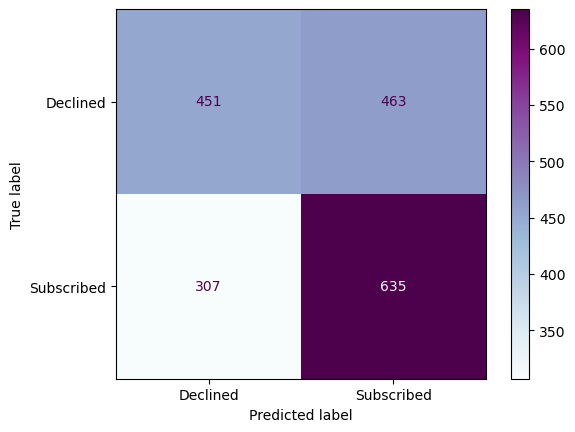

In [16]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Declined', 'Subscribed'])

cmd.plot(cmap='BuPu')
plt.grid(False)
plt.show()

## Baseline Results
The confusion matrix shows that the model did better guessing customers who subscribed. The baseline accuracy score is 60% with hyperparameter tuning and removing non-linear features this score will probably increase.

# Train Other Models
* KNN
* SVM
* Decision Trees

In [17]:
knn = KNeighborsClassifier()

start_time = time.time()
knn.fit(X_train, y_train)
end_time=time.time()

In [18]:
model = 'K-Nearest Neighbors'
training_time = end_time - start_time
training_acc = knn.score(X_train, y_train)
testing_acc = knn.score(X_test, y_test)
difference = training_acc - testing_acc
knn_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

models_df = pd.concat([models_df, knn_df], ignore_index=True)

In [19]:
svm = SVC()

start_time = time.time()
svm.fit(X_train, y_train)
end_time=time.time()

In [20]:
model = 'Support Vector Machines'
training_time = end_time - start_time
training_acc = svm.score(X_train, y_train)
testing_acc = svm.score(X_test, y_test)
difference = training_acc - testing_acc
svm_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

models_df = pd.concat([models_df, svm_df], ignore_index=True)

In [21]:
dt = DecisionTreeClassifier()

start_time = time.time()
dt.fit(X_train, y_train)
end_time=time.time()

In [22]:
model = 'Decision Tree'
training_time = end_time - start_time
training_acc = dt.score(X_train, y_train)
testing_acc = dt.score(X_test, y_test)
difference = training_acc - testing_acc
dt_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

models_df = pd.concat([models_df, dt_df], ignore_index=True)

## Model Comparisons
The KNN and Decision Tree models are overfitting. They do really well on seen data but there is a big drop when predicting on new data. KNN is expected to have the fastest training time because it doesn't perform any calculations until it makes predictions. The testing accuracy between the four models are comparable.

In [23]:
models_df

,model,training_time,training_acc,testing_acc,difference
0,Logistic Regression,0.013542,0.588631,0.585129,0.003502
1,K-Nearest Neighbors,0.004716,0.705954,0.549569,0.156385
2,Support Vector Machines,0.757126,0.593077,0.592134,0.000943
3,Decision Tree,0.009686,0.846175,0.555496,0.290679


# Hyperparameter Tuning and Cross Validation
Logistic Regression performs well with variables that have a linear relationship. Therefore, I will test it using only the 'marital' and 'default' features. The KNN model requires scaling of the data and removal of non-informative features to perform optimally. The Decision Tree model is prone to overfitting; to mitigate this, I will apply tree pruning techniques. Lastly, the SVM model may struggle with overlapping classes. To address this, I will reduce the noise in the data and assess any improvements.

In [24]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
dt = DecisionTreeClassifier()

## Tune Logistic Regression
Test hyperparameter tuning with same dataset as baseline. Second test will include only linear features. Logistic Regression will have 3 models in the comparisons.

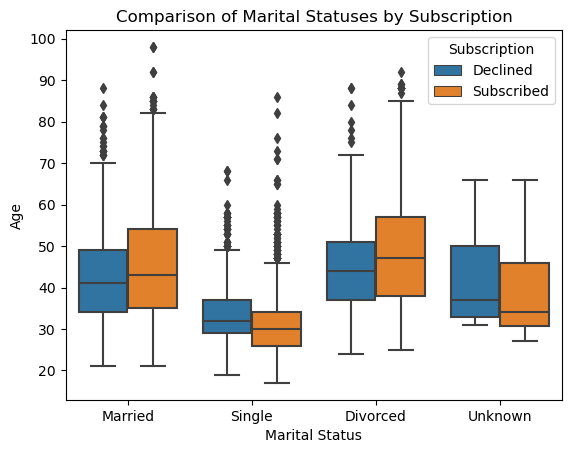

In [25]:
sns.boxplot(data=df, x='marital', y='age', hue='y')
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels([label.capitalize() for label in labels])

plt.xlabel('Marital Status')
plt.ylabel('Age')
plt.title('Comparison of Marital Statuses by Subscription')

legend_labels = ['Declined', 'Subscribed']
plt.legend(handles=handles, labels=legend_labels, title='Subscription')
plt.show()

In [26]:
param_grid = {
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
    'max_iter' : [1000,2000,3000,4000,5000]
}

lr_grid = GridSearchCV(lr, param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=10)

start_time = time.time()
lr_grid.fit(X_train, y_train)
end_time=time.time()

best_estimator = lr_grid.best_estimator_
best_params = lr_grid.best_params_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [27]:
model = 'Logistic Regression v2'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train, y_train)
testing_acc = best_estimator.score(X_test, y_test)
difference = training_acc - testing_acc

lr_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

In [28]:
models_df = pd.concat([models_df, lr_df], ignore_index=True)

## Logistic Regression Test With Only Relational Features

In [29]:
X_lr = X[['marital', 'default']].copy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_lr, y, test_size=0.2, random_state=42)
lr_2 = LogisticRegression()

param_grid = {
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
    'max_iter' : [1000,2000,3000,4000,5000]
}

lr2_grid = GridSearchCV(lr_2, param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=10)

start_time = time.time()
lr2_grid.fit(X_train2, y_train2)
end_time=time.time()

best_estimator = lr2_grid.best_estimator_
best_params = lr2_grid.best_params_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [30]:
model = 'Logistic Regression v3'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train2, y_train2)
testing_acc = best_estimator.score(X_test2, y_test2)
difference = training_acc - testing_acc

lr2_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

In [31]:
models_df = pd.concat([models_df, lr2_df], ignore_index=True)

## Logistic Regression Tuning Results
The default values were pretty good when compared to the hyperparameter tuning and cross validation. Testing the model with only the relational features decreased the score. This shows that those other features do contribute to the model's prediction score.

## Tune KNN

In [32]:
param_grid = {
    'n_neighbors': range(1, 20, 2),
    'weights': ['uniform', 'distance'],
    'leaf_size': range(1, 30, 1)
}

knn_grid = GridSearchCV(knn, param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=10)

start_time = time.time()
knn_grid.fit(X_train, y_train)
end_time=time.time()

best_estimator = knn_grid.best_estimator_
best_params = knn_grid.best_params_

Fitting 10 folds for each of 580 candidates, totalling 5800 fits


In [33]:
model = 'K-Nearest Neighbors v2'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train, y_train)
testing_acc = best_estimator.score(X_test, y_test)
difference = training_acc - testing_acc

knn_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

In [34]:
models_df = pd.concat([models_df, knn_df], ignore_index=True)

## KNN Tuning Results
This is one of the simplest models with not many parameters to tune. The increase in time was because of the 5800 models trained. The tuning helped with overfitting by half a percent. No testing difference was made from tuning this model.

## Tune SVM

In [35]:
param_grid = {
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'C': np.arange(0.1, 1.5, 0.1).tolist(),
    'degree': np.arange(1,6,1).tolist(),
}

svm_grid = GridSearchCV(svm, param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=10)

start_time = time.time()
svm_grid.fit(X_train, y_train)
end_time=time.time()

best_estimator = svm_grid.best_estimator_
best_params = svm_grid.best_params_

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


In [36]:
model = 'Support Vector Machines v2'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train, y_train)
testing_acc = best_estimator.score(X_test, y_test)
difference = training_acc - testing_acc

svm_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

In [37]:
models_df = pd.concat([models_df, svm_df], ignore_index=True)
models_df

,model,training_time,training_acc,testing_acc,difference
0,Logistic Regression,0.013542,0.588631,0.585129,0.003502
1,K-Nearest Neighbors,0.004716,0.705954,0.549569,0.156385
2,Support Vector Machines,0.757126,0.593077,0.592134,0.000943
3,Decision Tree,0.009686,0.846175,0.555496,0.290679
4,Logistic Regression v2,2.034496,0.589305,0.585129,0.004176
5,Logistic Regression v3,0.292011,0.558594,0.565194,-0.006600
6,K-Nearest Neighbors v2,7.139877,0.646417,0.565194,0.081223
7,Support Vector Machines v2,192.068723,0.593077,0.592134,0.000943


In [38]:
best_params

{'C': 1.0, 'degree': 1, 'kernel': 'rbf'}

## SVM Tuning Results
This model didn't really improve by much but it still has the highest accuracy score. The best params for this model were the 1.4 for the regularization parameter, 1 degree was the best out of 6, and rbf kernel outperformed the poly and sigmoid kernels.

## Tune Decision Trees

In [39]:
param_grid = {
    'ccp_alpha': [0, 0.002, 0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['random', 'best']
}

dt_grid = GridSearchCV(dt, param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=10)

start_time = time.time()
dt_grid.fit(X_train, y_train)
end_time=time.time()

best_estimator = dt_grid.best_estimator_
best_params = dt_grid.best_params_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [40]:
model = 'Decision Tree v2'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train, y_train)
testing_acc = best_estimator.score(X_test, y_test)
difference = training_acc - testing_acc

dt_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

In [41]:
models_df = pd.concat([models_df, dt_df], ignore_index=True)

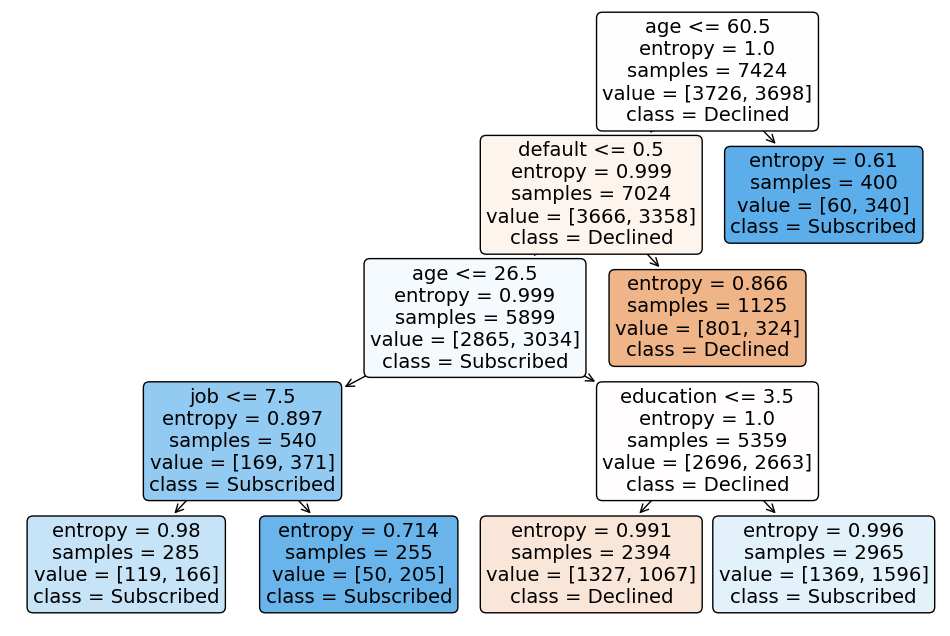

In [42]:
fig = plt.figure(figsize=(12,8))
_ = tree.plot_tree(best_estimator, feature_names=X.columns.tolist(), class_names=['Declined', 'Subscribed'],
                   filled=True, rounded=True)

plt.show()

In [43]:
sorted_idx = best_estimator.feature_importances_.argsort()[::-1]
feature_importances_df = pd.DataFrame({
    'Feature': X.columns[sorted_idx],
    'Importance': best_estimator.feature_importances_[sorted_idx]
}).reset_index(drop=True)

feature_importances_df

,Feature,Importance
0,age,0.521986
1,default,0.345273
2,education,0.078477
3,job,0.054263
4,loan,0.000000
5,housing,0.000000
6,marital,0.000000


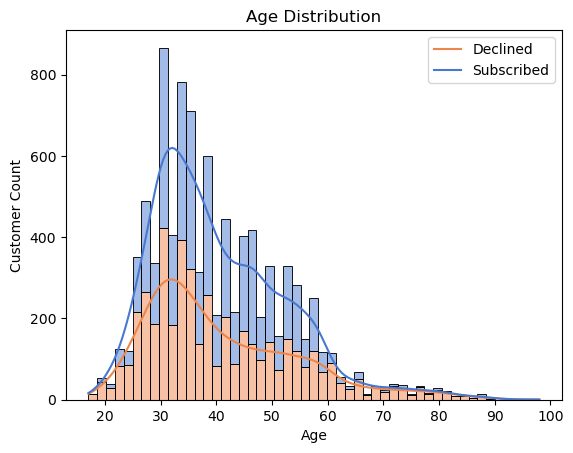

In [50]:
sns.histplot(data=df, x='age', hue='y', kde=True, multiple='stack', palette='muted')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Customer Count')
plt.legend(['Declined', 'Subscribed'])
plt.show()

## Decision Tree Tuning With Only Most Important Features

In [44]:
X_dt = X[['age', 'default']].copy()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_dt, y, test_size=0.2, random_state=42)
dt_3 = DecisionTreeClassifier()

param_grid = {
    'ccp_alpha': [0, 0.002, 0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['random', 'best']
}

dt3_grid = GridSearchCV(dt_3, param_grid, scoring='accuracy', verbose=1, n_jobs=-1, cv=10)

start_time = time.time()
dt3_grid.fit(X_train3, y_train3)
end_time=time.time()

best_estimator = dt3_grid.best_estimator_
best_params = dt3_grid.best_params_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [45]:
model = 'Decision Tree v3'
training_time = end_time - start_time
training_acc = best_estimator.score(X_train3, y_train3)
testing_acc = best_estimator.score(X_test3, y_test3)
difference = training_acc - testing_acc

dt3_df = pd.DataFrame({'model': model, 'training_time': training_time, 'training_acc': training_acc, 'testing_acc': testing_acc, 'difference': difference}, index=[0])

In [46]:
models_df = pd.concat([models_df, dt3_df], ignore_index=True)

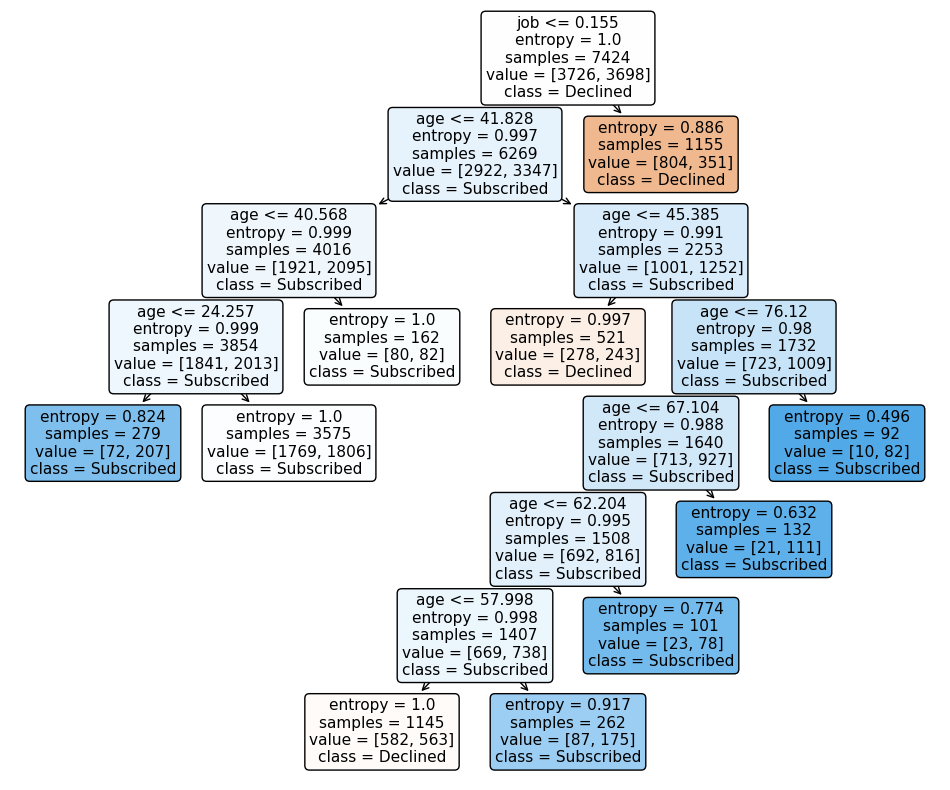

In [47]:
fig = plt.figure(figsize=(12,10))
_ = tree.plot_tree(best_estimator, feature_names=X.columns.tolist(), class_names=['Declined', 'Subscribed'],
                   filled=True, rounded=True)

plt.show()

## Decision Tree Tuning Results
The accuracy score remained consistent across all three models, with each scoring within the same range. The second model had a depth of 4, while the third model, which utilized only the most important features, had a depth of 5; however, the score remained unchanged.

# Findings
Some features proved to be more significant in certain models than in others. For instance, the Decision Tree model identified 'default status' and 'age' as the most crucial features, whereas the Logistic Regression model highlighted 'marital status' and 'default' as having the largest coefficients. A test was conducted focusing solely on these two most important features for each model—'Marital' and 'Default' for Logistic Regression, and 'Age' and 'Default' for Decision Trees. This led to a decrease in scores across all metrics, revealing that the less significant features still played a non-linear yet crucial role in predictions.

The baseline models employing default parameters, specifically for the K-Nearest Neighbor and Decision Trees, encountered overfitting issues. Despite achieving high training scores, their performance significantly dropped by 13% and 30%, respectively, when tested against unseen data.

Model tuning yielded only marginal improvements, as detailed in the subsequent table. These adjustments, however, mitigated the overfitting issue to some extent. Utilizing multiple cross-validation folds, ranging from 5 to 10, did not notably affect accuracy.

Alterations in parameters, such as class weighting and thresholds, slightly enhanced accuracy but were insufficient to address the underlying issue of class imbalance. Some models exhibited high precision but low recall scores, or vice versa, underscoring the challenges current machine learning models face with imbalanced classes. Although some features exhibited a linear relationship with the target variable, the majority showed non-linear relationships.

In [48]:
models_df

,model,training_time,training_acc,testing_acc,difference
0,Logistic Regression,0.013542,0.588631,0.585129,0.003502
1,K-Nearest Neighbors,0.004716,0.705954,0.549569,0.156385
2,Support Vector Machines,0.757126,0.593077,0.592134,0.000943
3,Decision Tree,0.009686,0.846175,0.555496,0.290679
4,Logistic Regression v2,2.034496,0.589305,0.585129,0.004176
5,Logistic Regression v3,0.292011,0.558594,0.565194,-0.006600
6,K-Nearest Neighbors v2,7.139877,0.646417,0.565194,0.081223
7,Support Vector Machines v2,192.068723,0.593077,0.592134,0.000943
8,Decision Tree v2,0.951120,0.597387,0.582974,0.014413
9,Decision Tree v3,0.275288,0.566406,0.572737,-0.006331


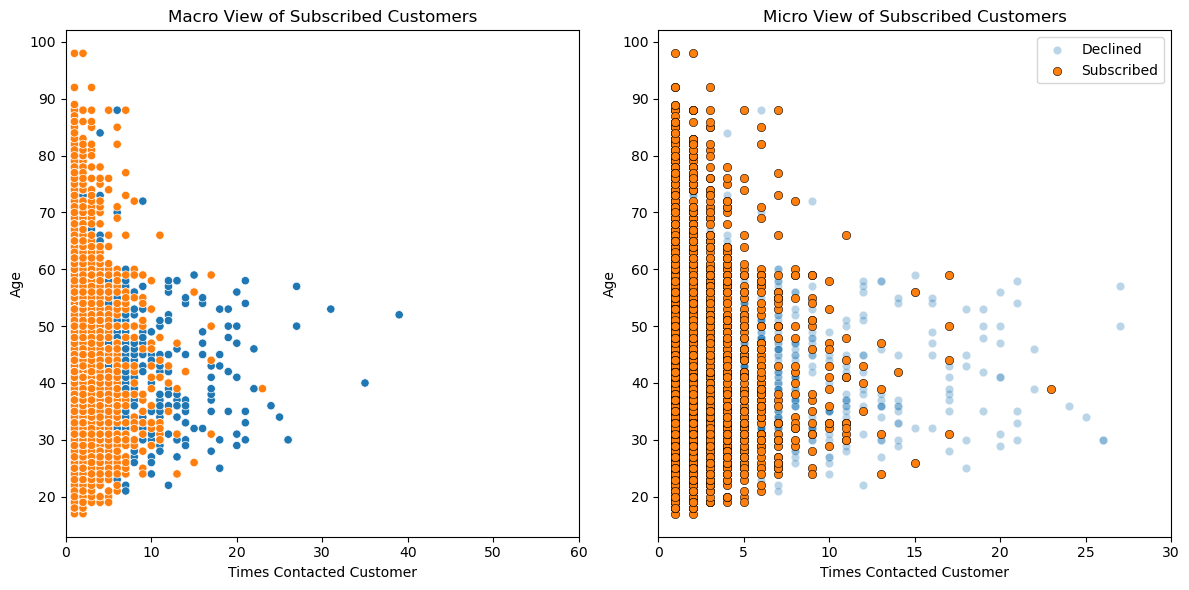

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
xlabel = 'Times Contacted Customer'
ylabel = 'Age'

sns.scatterplot(data=df, x='campaign', y='age', hue='y', ax=axs[0], legend=False)
axs[0].set_title('Macro View of Subscribed Customers')
axs[0].set_xlabel(xlabel)
axs[0].set_ylabel(ylabel)
axs[0].set_xlim(0,60)

sns.scatterplot(data=df[df['y'] == 0], x='campaign', y='age',  alpha=0.3, label='Declined', ax=axs[1])
sns.scatterplot(data=df[df['y'] == 1], x='campaign', y='age', edgecolor='black', linewidth=0.4, label='Subscribed', ax=axs[1])
axs[1].set_title('Micro View of Subscribed Customers')
axs[1].set_xlabel(xlabel)
axs[1].set_ylabel(ylabel)
axs[1].set_xlim(0, 30)
axs[1].legend()

plt.tight_layout()
plt.show()

# Next Steps and Recommendation
---
The next steps involve leveraging more sophisticated models to navigate the challenges presented by complex features and imbalanced classes:

Implement a Random Forest model: This approach addresses the issue of imbalanced classes by utilizing multiple decision trees. The previous decision tree analysis revealed a bias towards the 'default' class, which comprised 79% of the dataset. The Random Forest algorithm is expected to introduce diversity and broaden the decision framework, mitigating this bias.

Apply ensemble methods: Enhancing model diversity through ensemble techniques—specifically bagging and boosting—can significantly improve prediction accuracy. Bagging aggregates predictions from various models into a singular forecast, while boosting sequentially refines predictions by minimizing residual errors, using the outcomes of previous models to inform subsequent ones. Historically, combined models have shown superior performance over individual models in terms of prediction accuracy.

Explore Neural Networks: Given the non-linear relationships between features, neural networks present a promising avenue for identifying complex patterns within the data. An artificial neural network, capable of processing incomplete knowledge, will be pivotal in distilling insights from these intricate feature interactions.

Furthermore, it's recommended that the marketing team concentrates on key metrics: age, marital status, and number of contacts (campaigns). Analysis indicates that individuals within the 30 - 40 age bracket, particularly those who are married or divorced, exhibit higher subscription rates. Additionally, engagements leading to subscriptions typically involved fewer than five contacts. Therefore, it's advisable for the marketing team to design campaigns targeting the 30 to 40 age demographic, focusing on those who are married or have been married, with a communication cap of five contacts per customer.

